In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

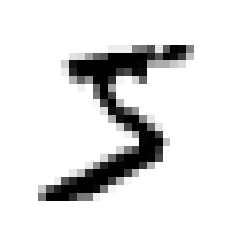

In [9]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = 'nearest')

plt.axis("off")
plt.show()

In [10]:
y[0]

'5'

In [11]:
import numpy as np
y = y.astype(np.uint8)

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a "5" detector (binary classification)

In [13]:
y_train_5 = (y_train == 5)

In [14]:
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

In [118]:
sgd_clf = SGDClassifier(random_state=42)

In [119]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#### Customizable s-kfold code

In [20]:
##for each fold, classifier object is cloned/instantiated, fit to stratified training fold, and evaluated for accuracy
##on stratified test fold
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [21]:
from sklearn.model_selection import cross_val_score

In [120]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [23]:
from sklearn.base import BaseEstimator

In [24]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()

In [121]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### Examining precision, recall, F1

In [41]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [29]:
from sklearn.metrics import precision_score, recall_score

In [30]:
precision_score(y_train_5, y_train_pred) # TP/TP+FP

0.8370879772350012

In [31]:
recall_score(y_train_5, y_train_pred) # TP/ TP+FN

0.6511713705958311

In [34]:
from sklearn.metrics import f1_score

In [35]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [125]:
y_scores = sgd_clf.decision_function([some_digit])

In [126]:
y_scores

array([2164.22030239])

In [127]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [128]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [165]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve

In [66]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [153]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlim(-40000, 40000)
    plt.grid()
    plt.axvline(x=threshold, color="r")
    #plt.axvline(x=np.interp(8000, recalls)color='grey')
    plt.xlabel('Threshold', fontsize=11)

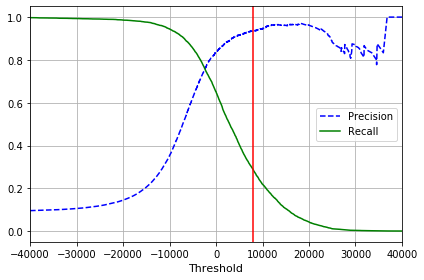

In [162]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.tight_layout()
plt.show()
#%matplotlib inline

In [102]:
'''some_digits = X[0:25]
some_digit_images=[]
for i,v in enumerate(some_digits):
    some_digit_images.append(some_digits[i].reshape(28,28))'''

In [155]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [166]:
threshold_90_precision

3370.0194991439557

In [167]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [168]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [169]:
 precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [170]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [171]:
from sklearn.metrics import roc_curve

In [172]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [190]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, label=None)
    plt.xlabel('Recall', fontsize=11)
    plt.ylabel('Precision', fontsize=11)

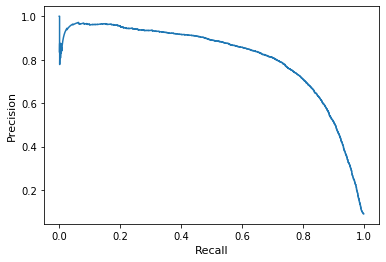

In [191]:
plot_precision_vs_recall(precisions, recalls)

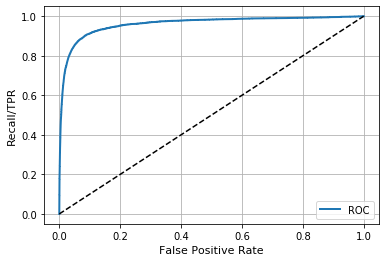

In [179]:
def plot_roc_curve(fpr, tpr, label='ROC'):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.grid()
    plt.legend()# Add axis labels and grid
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('Recall/TPR', fontsize=11)
plot_roc_curve(fpr, tpr)
plt.show()

In [174]:
from sklearn.metrics import roc_auc_score

In [175]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Comparing RFClassifier vs SGDClassifier

In [192]:
from sklearn.ensemble import RandomForestClassifier

In [193]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
